# Assignment II.
### *Stochastic Simulation*
#### Group 6
- Marcell Szegedi - 15722635
- Yuxin Dong - 15550397
- Koen Verlaan - 11848316

**Import Libraries**

In [74]:
import os
from IPython.display import clear_output

import numpy as np
import simpy
import matplotlib.pyplot as plt
import random
from scipy import stats
import math

**Output Libraries**

In [84]:
output_task_2 = r"Figures/task_2"
output_taks_3 = r"Figures/task_3"
output_task_4 = r"Figures/task_4"

# Models

##### M/M/n

In [32]:
class MMnQueueExperiment:
    def __init__(
            self,
            env: simpy.Environment,
            server: simpy.Resource,
            n_jobs: int,
            avg_arrival_time: float,
            avg_service_time: float):
        self.env = env
        self.server = server
        self.n_jobs = n_jobs
        self.avg_arrival_time = avg_arrival_time
        self.avg_service_time = avg_service_time
        self.waiting_times = []

    @classmethod
    def run_experiment(
            cls,
            n_servers: int,
            n_jobs: int,
            avg_arrival_time: float,
            avg_service_time: float
    ) -> np.ndarray:
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n_servers)
        experiment = cls(env, server, n_jobs, avg_arrival_time, avg_service_time)
        experiment.env.process(experiment.job_arrival())
        experiment.env.run()
        return np.array(experiment.waiting_times)

    def job_arrival(self):
        for _ in range(self.n_jobs):
            yield self.env.timeout(np.random.exponential(self.avg_arrival_time))
            self.env.process(self.job_life())

    def job_life(self):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            service_start_time = self.env.now
            yield self.env.timeout(np.random.exponential(self.avg_service_time))

        self.waiting_times.append(service_start_time - arrival_time)

##### M/D/n

In [33]:
class MDnQueueExperiment:
    def __init__(
            self,
            env: simpy.Environment,
            server: simpy.Resource,
            n_jobs: int,
            avg_arrival_time: float,
            det_service_time: float):
        self.env = env
        self.server = server
        self.n_jobs = n_jobs
        self.avg_arrival_time = avg_arrival_time
        self.det_service_time = det_service_time
        self.waiting_times = []

    @classmethod
    def run_experiment(
            cls,
            n_servers: int,
            n_jobs: int,
            avg_arrival_time: float,
            det_service_time: float
    ) -> np.ndarray:
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n_servers)
        experiment = cls(env, server, n_jobs, avg_arrival_time, det_service_time)
        experiment.env.process(experiment.job_arrival())
        experiment.env.run()
        return np.array(experiment.waiting_times)

    def job_arrival(self):
        for _ in range(self.n_jobs):
            yield self.env.timeout(np.random.exponential(self.avg_arrival_time))
            self.env.process(self.job_life())

    def job_life(self):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            service_start_time = self.env.now
            yield self.env.timeout(self.det_service_time)

        self.waiting_times.append(service_start_time - arrival_time)

##### M/H/n

In [34]:
class MHnQueueExperiment:
    def __init__(
            self,
            env: simpy.Environment,
            server: simpy.Resource,
            n_jobs: int,
            avg_arrival_time: float,
            p_exp_1: float,
            p_exp_2: float,
            avg_service_time_1: float,
            avg_service_time_2: float):
        self.env = env
        self.server = server
        self.n_jobs = n_jobs
        self.avg_arrival_time = avg_arrival_time
        self.p_exp_1 = p_exp_1
        self.avg_service_time_1 = avg_service_time_1
        self.p_exp_2 = p_exp_2
        self.avg_service_time_2 = avg_service_time_2
        self.waiting_times = []

    @classmethod
    def run_experiment(
            cls,
            n_servers: int,
            n_jobs: int,
            avg_arrival_time: float,
            p_exp_1: float,
            p_exp_2: float,
            avg_service_time_1: float,
            avg_service_time_2: float
    ) -> np.ndarray:
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=n_servers)
        experiment = cls(env, server, n_jobs, avg_arrival_time, p_exp_1, p_exp_2, avg_service_time_1, avg_service_time_2)
        experiment.env.process(experiment.job_arrival())
        experiment.env.run()
        return np.array(experiment.waiting_times)

    def job_arrival(self):
        for _ in range(self.n_jobs):
            yield self.env.timeout(np.random.exponential(self.avg_arrival_time))
            self.env.process(self.job_life())

    def job_life(self):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            service_start_time = self.env.now
            yield self.env.timeout(self.hyper_exp_sampling(self.p_exp_1,
                                                           self.p_exp_2,
                                                           self.avg_service_time_1,
                                                           self.avg_service_time_2))

        self.waiting_times.append(service_start_time - arrival_time)

    @staticmethod
    def hyper_exp_sampling(p1: float, p2: float, avg_service_time_1: float, avg_service_time_2: float) -> float:
        if p1 + p2 != 1 or not (0 <= p1 <= 1) or not (0 <= p2 <= 1):
            raise ValueError("Probabilities must sum to 1.")
        if avg_service_time_1 <= 0 or avg_service_time_2 <= 0:
            raise ValueError("Parameters of the exponential distributions are not valid.")

        if random.random() < p1:
            return np.random.exponential(avg_service_time_1)
        else:
            return np.random.exponential(avg_service_time_2)

##### M/M/n with Priority to smaller jobs

In [35]:
class MMnPRIORITYQueueExperiment:
    def __init__(
            self,
            env: simpy.Environment,
            server: simpy.Resource,
            n_jobs: int,
            avg_arrival_time: float,
            avg_service_time: float):
        self.env = env
        self.server = server
        self.n_jobs = n_jobs
        self.avg_arrival_time = avg_arrival_time
        self.avg_service_time = avg_service_time
        self.waiting_times = []

    @classmethod
    def run_experiment(
            cls,
            n_servers: int,
            n_jobs: int,
            avg_arrival_time: float,
            avg_service_time: float
    ) -> np.ndarray:
        env = simpy.Environment()
        server = simpy.PriorityResource(env, capacity=n_servers)
        experiment = cls(env, server, n_jobs, avg_arrival_time, avg_service_time)
        experiment.env.process(experiment.job_arrival())
        experiment.env.run()
        return np.array(experiment.waiting_times)

    def job_arrival(self):
        for _ in range(self.n_jobs):
            yield self.env.timeout(np.random.exponential(self.avg_arrival_time))
            job_size = np.random.exponential(self.avg_service_time)
            self.env.process(self.job_life(job_size))

    def job_life(self, job_size: float):
        arrival_time = self.env.now
        with self.server.request(priority=job_size) as request:
            yield request
            service_start_time = self.env.now
            yield self.env.timeout(job_size)

        self.waiting_times.append(service_start_time - arrival_time)

# Calculations

##### Functions

In [36]:
def calc_pi_w(n: int, rho: float) -> float:
    if rho >= 1 or rho <= 0:
        raise ValueError("Server utilization must be in the open interval (0, 1).")
    
    term_1 = (n * rho) ** n / (math.factorial(n))
    term_2 = np.sum([(n * rho) ** k / math.factorial(k) for k in range(n)])

    return term_1 / (term_1 + (1 - rho) * term_2)

##### Calculations

In [37]:
rhos = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
n = np.arange(1, 101)

pis = np.array([[calc_pi_w(n_val, rho_val) for rho_val in rhos] for n_val in n])

##### Plotting the results

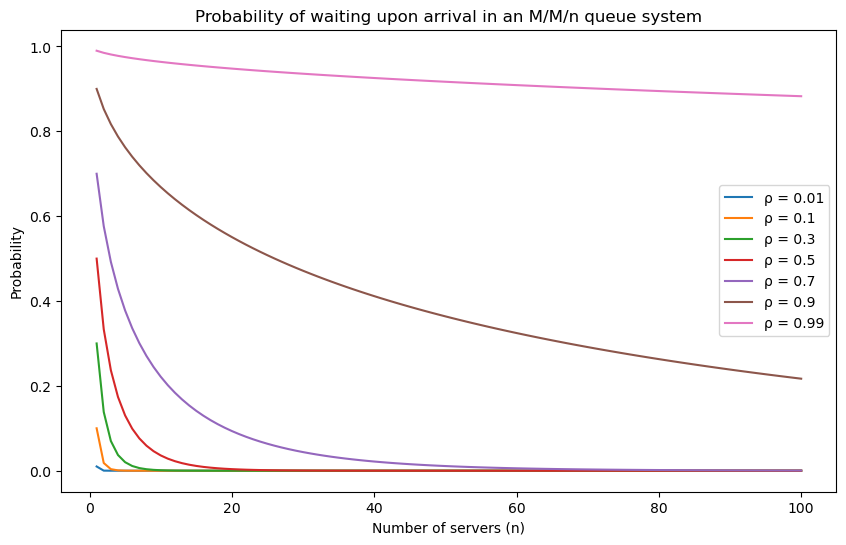

In [ ]:
# Create Figure
plt.figure(figsize=(10, 6))

# Plot
for rho_val_idx in range(len(rhos)):
    plt.plot(n, pis[:, rho_val_idx], label=f"ρ = {rhos[rho_val_idx]}")

# Add chart elements
plt.title("Probability of waiting upon arrival in an M/M/n queue system")
plt.xlabel("Number of servers (n)")
plt.ylabel("Probability")
plt.legend()

# Save and show
plt.savefig(os.path.join(output_task_2, "prob_of_waiting.png"), dpi=300)
plt.show()

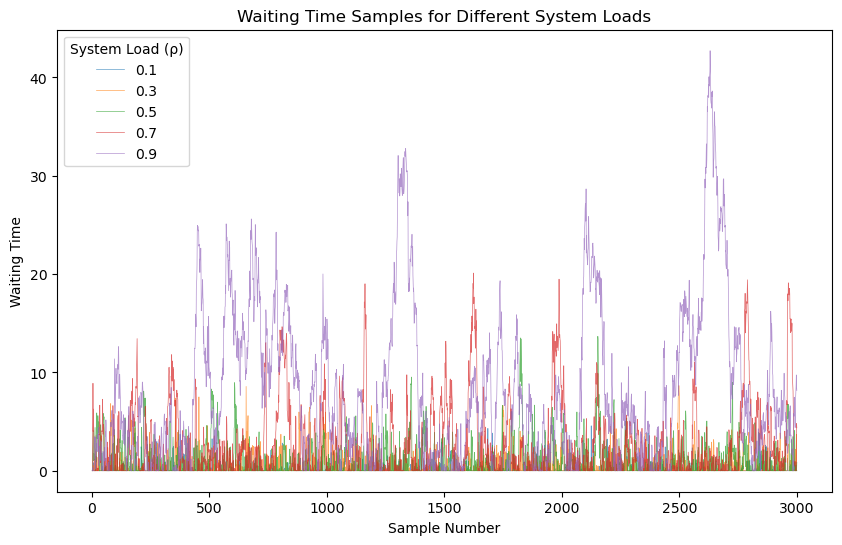

In [100]:
# Calculating the the required cut_off to reach steady state
rhos = [0.1, 0.3, 0.5, 0.7, 0.9]
sample_size = 3000
mu = 1

plt.figure(figsize=(10, 6))

for rho in rhos:
    lambda_par = rho * mu
    waiting_times = MMnQueueExperiment.run_experiment(1, sample_size, 1 / lambda_par, 1 / mu)
    plt.plot(np.arange(1, sample_size + 1), waiting_times, label=f"{rho}", alpha=0.7, linewidth=0.5)

plt.title("Waiting Time Samples for Different System Loads")
plt.xlabel("Sample Number")
plt.ylabel("Waiting Time")
plt.legend(title="System Load (ρ)")

# plt.savefig(os.path.join(output_taks_3, "waiting_time_samples.png"), dpi=300)
plt.show()

# Hypothesis Testing

##### Functions

In [104]:
def one_tailed_z_test(sample_1: np.ndarray, sample_2: np.ndarray) -> float:
    """The function perform a one-tailed z-test for the difference of means of the two samples,
    where the null hypothesis is that the mean of the sample_1 is less than or equal to the mean of the sample_2."""
    mean_1 = np.mean(sample_1)
    mean_2 = np.mean(sample_2)
    var_1 = np.var(sample_1, ddof=1)
    var_2 = np.var(sample_2, ddof=1)
    
    se = np.sqrt(var_1 / len(sample_1) + var_2 / len(sample_2))

    z = (mean_1  - mean_2) / se
    p_value = 1 - stats.norm.cdf(z)

    return p_value, se

def calc_expected_waiting_time_for_mmn(n: int, rho: float, mu: float) -> float:
    if rho >= 1 or rho <= 0:
        raise ValueError("Server utilization must be in the open interval (0, 1).")
    
    if n == 1:
        return rho / (mu * (1 - rho))

    pi = calc_pi_w(n, rho)
    return pi / (mu * n * (1 - rho))

##### M/M/1 vs M/M/2

In [108]:
# Fixing seed for reproducibility
np.random.seed(100)
random.seed(100)

#####################

# Hypothesis testing for the MM1 vs MMn queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
n = 2
lambda_1 = rho * mu
lambda_2 = n * lambda_1

waiting_times_mm1 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_mm2 = MMnQueueExperiment.run_experiment(n, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_mm1[cut_off_size:], waiting_times_mm2[cut_off_size:])
print(f"The mean waiting time for MM1 is {np.mean(waiting_times_mm1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM2 is {np.mean(waiting_times_mm2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM1 vs MM2 queue: {p_value}")

# Theoretical waiting time for MM1
theoretical_mean_waiting_time_1 = calc_expected_waiting_time_for_mmn(1, rho, mu)
theoretical_mean_waiting_time_2 = calc_expected_waiting_time_for_mmn(n, rho, mu)
print(f"Theoretical mean waiting time for MM1: {theoretical_mean_waiting_time_1:.4f}")
print(f"Theoretical mean waiting time for MM2: {theoretical_mean_waiting_time_2:.4f}")

The mean waiting time for MM1 is 17.3057
The mean waiting time for MM2 is 9.3589
The Standard error for the difference of means: 0.0634
p-value for the MM1 vs MM2 queue: 0.0
Theoretical mean waiting time for MM1: 19.0000
Theoretical mean waiting time for MM2: 9.2564


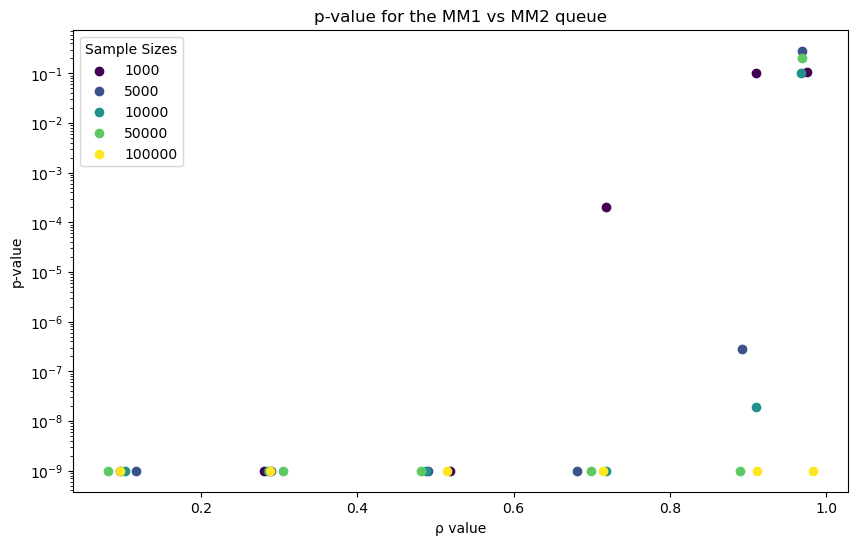

In [ ]:
# Fixing seed for reproducibility
np.random.seed(150)
random.seed(150)

#####################

sample_sizes = [1000, 5000, 10000, 50000, 100000]
cut_off_size = 500
rhos = [0.1, 0.3, 0.5, 0.7, 0.9, 0.98]
mu = 1
n = 2

recalc = 10

# Define colors for each sample size
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))

# Create Figure
plt.figure(figsize=(10, 6))

# To track labels for the legend
plotted_labels = set()

# Loop over sample sizes and rhos
for idx, sample_size in enumerate(sample_sizes):
    color = colors[idx]  # Assign a unique color to each sample size
    for rho in rhos:
        lambda_1 = rho * mu
        lambda_2 = n * lambda_1
        p_value_set = []
        for _ in range(recalc):
            waiting_times_mm1 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
            waiting_times_mm2 = MMnQueueExperiment.run_experiment(n, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)
            p_value_set.append(one_tailed_z_test(waiting_times_mm1[cut_off_size:], waiting_times_mm2[cut_off_size:]))
        
        p_value = np.mean(p_value_set)
        if p_value < 0.000000001:
            p_value = 0.000000001
        
        # Add jitter to the rho value
        jitter = np.random.uniform(-0.02, 0.02)  # Adjust jitter magnitude as needed
        jittered_rho = rho + jitter
        
        # Add label only once per sample size
        label = f"{sample_size}" if sample_size not in plotted_labels else None
        plotted_labels.add(sample_size)

        # Plot the scatter point
        plt.scatter(jittered_rho, p_value, color=color, label=label)

        print(f"Rho: {rho} DONE")
    print(f"Sample Size: {sample_size} DONE")

# Add legend, labels, and save the plot
plt.title("p-value for the MM1 vs MM2 queue")
plt.xlabel("ρ value")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend(title="Sample Sizes", loc="best")

clear_output()
# plt.savefig(os.path.join(output_task_2, "p_values.png"), dpi=300)
plt.show()

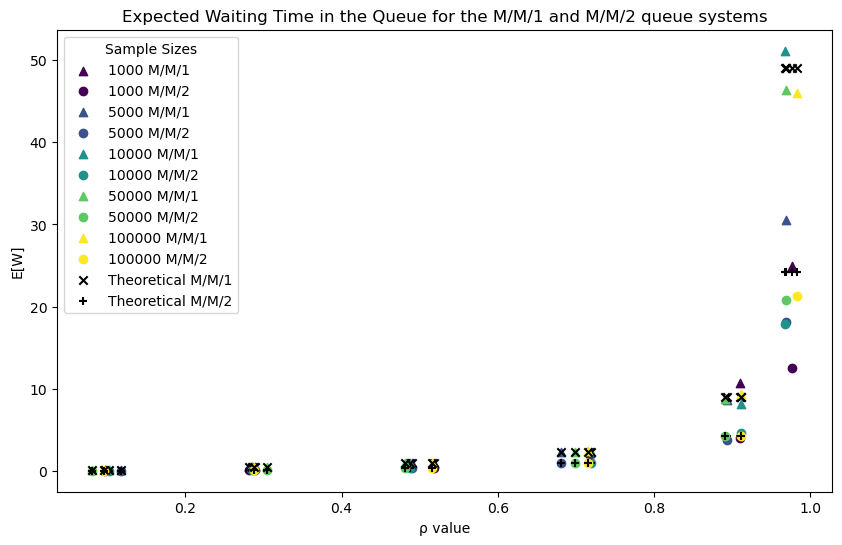

In [83]:
# Fixing seed for reproducibility
np.random.seed(150)
random.seed(150)

#####################

sample_sizes = [1000, 5000, 10000, 50000, 100000]
cut_off_size = 500
rhos = [0.1, 0.3, 0.5, 0.7, 0.9, 0.98]
mu = 1
n = 2

recalc = 10

# Define colors for each sample size
colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))

# Create Figure
plt.figure(figsize=(10, 6))

# To track labels for the legend
plotted_labels = set()

# Loop over sample sizes and rhos
for idx, sample_size in enumerate(sample_sizes):
    color = colors[idx]  # Assign a unique color to each sample size
    for rho in rhos:
        lambda_1 = rho * mu
        lambda_2 = n * lambda_1

        mean_set_1 = []
        mean_set_2 = []
        for _ in range(recalc):
            waiting_times_mm1 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
            waiting_times_mm2 = MMnQueueExperiment.run_experiment(n, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)
            mean_set_1.append(np.mean(waiting_times_mm1[cut_off_size:]))
            mean_set_2.append(np.mean(waiting_times_mm2[cut_off_size:]))

        mean_1 = np.mean(mean_set_1)
        mean_2 = np.mean(mean_set_2)
        
        # Add jitter to the rho value
        jitter = np.random.uniform(-0.02, 0.02)  # Adjust jitter magnitude as needed
        jittered_rho = rho + jitter
        
        # Add label only once per sample size
        label = f"{sample_size}" if sample_size not in plotted_labels else None
        plotted_labels.add(sample_size)

        # Plot the scatter point
        plt.scatter(jittered_rho, mean_1, color=color, label=f"{label} M/M/1" if label is not None else None, marker='^')
        plt.scatter(jittered_rho, mean_2, color=color, label=f"{label} M/M/2" if label is not None else None, marker='o')

        # Calculate Theoretical Values
        theoretical_mean_waiting_time_1 = calc_expected_waiting_time_for_mmn(1, rho, mu)
        theoretical_mean_waiting_time_2 = calc_expected_waiting_time_for_mmn(n, rho, mu)
        plt.scatter(jittered_rho, theoretical_mean_waiting_time_1, color='black', marker='x', label=f"Theoretical M/M/1" if label == str(sample_sizes[-1]) else None)
        plt.scatter(jittered_rho, theoretical_mean_waiting_time_2, color='black', marker='+', label=f"Theoretical M/M/2" if label == str(sample_sizes[-1]) else None)

        print(f"Rho: {rho} DONE")
    print(f"Sample Size: {sample_size} DONE")

# Add legend, labels, and save the plot
plt.title("Expected Waiting Time in the Queue for the M/M/1 and M/M/2 queue systems")
plt.xlabel("ρ value")
plt.ylabel("E[W]")
plt.legend(title="Sample Sizes", loc="best")

clear_output()
plt.savefig(os.path.join(output_task_2, "true_vs_estimated_wait_times.png"), dpi=300)
plt.show()

##### M/M/1 vs M/M/4

In [ ]:
# Fixing seed for reproducibility
np.random.seed(200)
random.seed(200)

#####################

# Hypothesis testing for the MM1 vs MMn queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
n = 4
lambda_1 = rho * mu
lambda_2 = n * lambda_1

waiting_times_1 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_2 = MMnQueueExperiment.run_experiment(n, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MM1 is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM2 is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM1 vs MM2 queue: {p_value}")

# Theoretical waiting time for MM1
theoretical_mean_waiting_time_1 = calc_expected_waiting_time_for_mmn(1, rho, mu)
theoretical_mean_waiting_time_2 = calc_expected_waiting_time_for_mmn(n, rho, mu)
print(f"Theoretical mean waiting time for MM1: {theoretical_mean_waiting_time_1:.4f}")
print(f"Theoretical mean waiting time for MM2: {theoretical_mean_waiting_time_2:.4f}")

The mean waiting time for MM1 is 17.1218
The mean waiting time for MM2 is 4.1173
The Standard error for the difference of means: 0.0606
p-value for the MM1 vs MM2 queue: 0.0
Theoretical mean waiting time for MM1: 19.0000
Theoretical mean waiting time for MM2: 4.4571


##### M/M/2 vs M/M/4

In [ ]:
# Fixing seed for reproducibility
np.random.seed(300)
random.seed(300)

#####################

# Hypothesis testing for the MM2 vs MM4 queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
n_1 = 2
n_2 = 4
lambda_1 = rho * mu * n_1
lambda_2 = rho * mu * n_2

waiting_times_mm2 = MMnQueueExperiment.run_experiment(n_1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_mm4 = MMnQueueExperiment.run_experiment(n_2, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_mm2[cut_off_size:], waiting_times_mm4[cut_off_size:])
print(f"The mean waiting time for MM2 is {np.mean(waiting_times_mm2[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM4 is {np.mean(waiting_times_mm4[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM2 vs MM4 queue: {p_value}")

# Theoretical waiting time for MM1
theoretical_mean_waiting_time_1 = calc_expected_waiting_time_for_mmn(n_1, rho, mu)
theoretical_mean_waiting_time_2 = calc_expected_waiting_time_for_mmn(n_2, rho, mu)
print(f"Theoretical mean waiting time for MM2: {theoretical_mean_waiting_time_1:.4f}")
print(f"Theoretical mean waiting time for MM4: {theoretical_mean_waiting_time_2:.4f}")

The mean waiting time for MM2 is 9.1883
The mean waiting time for MM4 is 4.3610
The Standard error for the difference of means: 0.0363
p-value for the MM2 vs MM4 queue: 0.0
Theoretical mean waiting time for MM2: 9.2564
Theoretical mean waiting time for MM4: 4.4571


##### M/M/1 priority vs M/M/1

In [ ]:
# Fixing seed for reproducibility
np.random.seed(500)
random.seed(500)

#####################

# Hypothesis testing for the MM1 vs MM1 Priority queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
lambda_1 = rho * mu

waiting_times_1 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_2 = MMnPRIORITYQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MM1 is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM1 Priority is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM1 vs MM1 Priority queue: {p_value}")

The mean waiting time for MM1 is 15.5855
The mean waiting time for MM1 Priority is 5.1209
The Standard error for the difference of means: 0.1247
p-value for the MM1 vs MM1 Priority queue: 0.0


##### M/M/1 priority vs M/M/4

In [ ]:
# Fixing seed for reproducibility
np.random.seed(600)
random.seed(600)

#####################

# Hypothesis testing for the MM1 vs MM1 Priority queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
lambda_1 = rho * mu
lambda_2 = lambda_1 * 4

waiting_times_2 = MMnQueueExperiment.run_experiment(4, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)
waiting_times_1 = MMnPRIORITYQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MM1 Priority is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM4 is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM1 Priority vs MM4 queue: {p_value}")

The mean waiting time for MM1 Priority is 5.2161
The mean waiting time for MM4 is 3.8834
The Standard error for the difference of means: 0.1445
p-value for the MM1 Priority vs MM4 queue: 0.0


##### M/M/4 vs M/M/2 Priority

In [133]:
# Fixing seed for reproducibility
np.random.seed(600)
random.seed(600)

#####################

# Hypothesis testing for the MM1 vs MM1 Priority queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
lambda_1 = rho * mu * 2
lambda_2 = rho * mu * 4

waiting_times_1 = MMnQueueExperiment.run_experiment(4, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)
waiting_times_2 = MMnPRIORITYQueueExperiment.run_experiment(2, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MM4 is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM2 Priority is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM2 Priority vs MM4 queue: {p_value}")

The mean waiting time for MM4 is 3.8834
The mean waiting time for MM2 Priority is 2.6854
The Standard error for the difference of means: 0.0707
p-value for the MM2 Priority vs MM4 queue: 0.0


##### M/D/1 vs M/M/1

In [117]:
# Fixing seed for reproducibility
np.random.seed(600)
random.seed(600)

#####################

# Hypothesis testing for the MD1 vs MM1 queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
lambda_1 = rho * mu

waiting_times_1 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_2 = MDnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MM1 Priority is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MD1 is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MD1 Priority vs MM1 queue: {p_value}")

The mean waiting time for MM1 Priority is 18.4801
The mean waiting time for MD1 is 9.4932
The Standard error for the difference of means: 0.0664
p-value for the MD1 Priority vs MM1 queue: 0.0


##### M/D/1 vs M/M/2

In [130]:
# Fixing seed for reproducibility
np.random.seed(700)
random.seed(700)

#####################

# Hypothesis testing for the MD1 vs MM1 queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
mu = 1
n = 2
lambda_1 = rho * mu
lambda_2 = lambda_1 * n

waiting_times_1 = MMnQueueExperiment.run_experiment(n, sample_size + cut_off_size, 1 / lambda_2, 1 / mu)
waiting_times_2 = MDnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MM2 Priority is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MD1 is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MD1 vs MM2 queue: {p_value}")

The mean waiting time for MM2 Priority is 9.1395
The mean waiting time for MD1 is 9.9758
The Standard error for the difference of means: 0.0451
p-value for the MD1 vs MM2 queue: 1.0


##### M/H/1 vs M/M/1

In [126]:
# Fixing seed for reproducibility
np.random.seed(700)
random.seed(700)

#####################

# Hypothesis testing for the MD1 vs MM1 queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
p1 = 0.75
p2 = 0.25
avg_service_time_1 = 0.5
avg_service_time_2 = 2.5
exp_service_time_for_hyper = p1 * avg_service_time_1 + p2 * avg_service_time_2
mu = 1 / exp_service_time_for_hyper
lambda_1 = rho * mu

waiting_times_2 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_1 = MHnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, p1, p2, avg_service_time_1, avg_service_time_2)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MH1 is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM1 is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM1 vs MH1 queue: {p_value}")

The mean waiting time for MH1 is 32.8155
The mean waiting time for MM1 is 17.1725
The Standard error for the difference of means: 0.1073
p-value for the MM1 vs MH1 queue: 0.0


##### M/H/2 vs M/M/1

In [131]:
# Fixing seed for reproducibility
np.random.seed(700)
random.seed(700)

#####################

# Hypothesis testing for the MD1 vs MM1 queues

# Test Settings
sample_size = 100000
cut_off_size = 1000

# Parameters
rho = 0.95
p1 = 0.75
p2 = 0.25
avg_service_time_1 = 0.5
avg_service_time_2 = 2.5
exp_service_time_for_hyper = p1 * avg_service_time_1 + p2 * avg_service_time_2
mu = 1 / exp_service_time_for_hyper
lambda_1 = rho * mu
n = 2
lambda_2 = lambda_1 * n

waiting_times_2 = MMnQueueExperiment.run_experiment(1, sample_size + cut_off_size, 1 / lambda_1, 1 / mu)
waiting_times_1 = MHnQueueExperiment.run_experiment(n, sample_size + cut_off_size, 1 / lambda_2, p1, p2, avg_service_time_1, avg_service_time_2)

p_value, se = one_tailed_z_test(waiting_times_1[cut_off_size:], waiting_times_2[cut_off_size:])
print(f"The mean waiting time for MH2 is {np.mean(waiting_times_1[cut_off_size:]):.4f}")
print(f"The mean waiting time for MM1 is {np.mean(waiting_times_2[cut_off_size:]):.4f}")
print(f"The Standard error for the difference of means: {se:.4f}")
print(f"p-value for the MM1 vs MH2 queue: {p_value}")

The mean waiting time for MH2 is 15.1786
The mean waiting time for MM1 is 17.1725
The Standard error for the difference of means: 0.0717
p-value for the MM1 vs MH2 queue: 1.0
